In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from PreProcess import preprocess

In [26]:
df = preprocess("housing_data.csv", "MEDV", ["RM", "AGE", "DIS", "LSTAT"])
features=["RM", "AGE", "DIS", "LSTAT"]

In [27]:
def norm0_residuals_objective(beta, X, y):
    bias = beta[0]
    weights = beta[1:]
    residuals = y - (X @ weights + bias)
    norm0 = np.sum(np.abs(residuals) > 1e-6) 
    return norm0

def norm1_residuals_objective(beta, X, y):
    bias = beta[0]
    weights = beta[1:]
    residuals = y - (X @ weights + bias)
    norm1 = np.sum(np.abs(residuals))
    return norm1

def norm2_residuals_objective(beta, X, y):
    bias = beta[0]
    weights = beta[1:]
    residuals = y - (X @ weights + bias)
    norm2 = np.sqrt(np.sum(residuals**2)) 
    return norm2

def norm_infinity_residuals_objective(beta, X, y):
    bias = beta[0]
    weights = beta[1:]
    residuals = y - (X @ weights + bias)
    norm_infinity = np.max(np.abs(residuals))
    return norm_infinity

In [28]:
def generate_graphical_table(data, columns, title):
    df = pd.DataFrame(data, columns=columns)
    fig, ax = plt.subplots(figsize=(2,2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.title(title)
    plt.show()

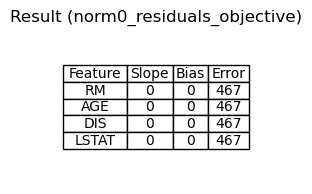

**************************************************


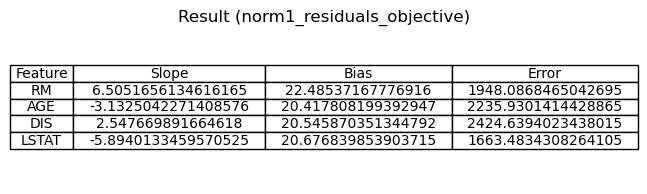

**************************************************


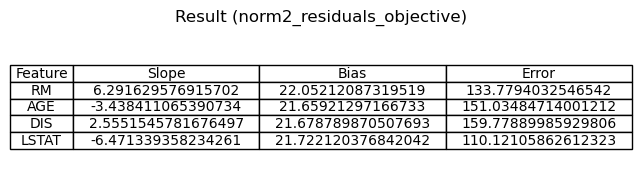

**************************************************


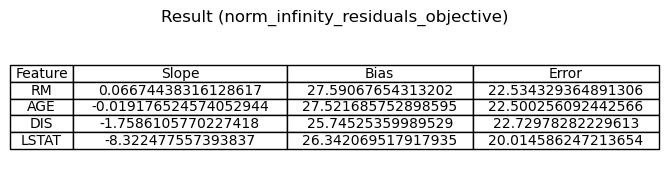

**************************************************


In [29]:
if __name__ == "__main__":
    norms = [norm0_residuals_objective, norm1_residuals_objective, norm2_residuals_objective, norm_infinity_residuals_objective]
    for norm in norms:
        results = []
        slopes_biases = {"slopes": {}, "biases": {}}
        for feature in ["RM", "AGE", "DIS", "LSTAT"]:
            X = df[feature].values.reshape(-1, 1)
            y = df["MEDV"]
            objective_function = lambda beta: norm(beta, X, y)
            initial_beta = [0, 0]
            sa = SimulatedAnnealing(
                objective_function=objective_function,
                initial_solution=initial_beta,
                max_iter=1000,
                initial_temp=1.0,
                cooling_rate=0.99
            )
            best_beta, best_cost = sa.minimize()
            slopes_biases["slopes"][feature] = best_beta[1]
            slopes_biases["biases"][feature] = best_beta[0]
            results.append([feature, best_cost, best_beta[1], best_beta[0]])

        generate_graphical_table(
            [[r[0], r[2], r[3],r[1]] for r in results],
            columns=["Feature", "Slope", "Bias", "Error"],
            title=f"Result ({norm.__name__})"
        )

        print("*"*50)

In [30]:
def norm_0(y_true, y_pred):
    error = y_true - y_pred
    return np.count_nonzero(error)

def norm_1(y_true, y_pred):
    error = y_true - y_pred
    return np.sum(np.abs(error))

def norm_2(y_true, y_pred):
    error = y_true - y_pred
    return np.sqrt(np.sum(error**2))

def norm_inf(y_true, y_pred):
    error = y_true - y_pred
    return np.max(np.abs(error))

In [31]:
def linear_regression(y_true, X, error_norm_function):
    def cost_function(params):
        alpha, beta = params[0], params[1]
        y_pred = alpha + beta * X
        return error_norm_function(y_true, y_pred)
    initial_guess = [0, 0]
    result = minimize(cost_function, initial_guess, method='Nelder-Mead')
    optimal_alpha, optimal_beta = result.x
    optimal_error = cost_function([optimal_alpha, optimal_beta])
    return optimal_alpha, optimal_beta, optimal_error

In [32]:
if __name__ == "__main__":
    X = df['RM']
    y_true =  df['MEDV']
    norms = [norm_0, norm_1, norm_2, norm_inf]
    for norm_func in norms:
        optimal_alpha, optimal_beta, optimal_error = linear_regression(y_true, X, error_norm_function=norm_func)
        print(f"Using {norm_func.__name__}: Optimal alpha = {optimal_alpha:.2f}, Optimal beta = {optimal_beta:.2f}, Error = {optimal_error:.2f}")

Using norm_0: Optimal alpha = 0.00, Optimal beta = 0.00, Error = 467.00
Using norm_1: Optimal alpha = 22.49, Optimal beta = 6.51, Error = 1948.08
Using norm_2: Optimal alpha = 22.05, Optimal beta = 6.29, Error = 133.78
Using norm_inf: Optimal alpha = 27.81, Optimal beta = -1.16, Error = 24.18
